<a href="https://colab.research.google.com/github/NayeonKeum/SOLUX_summer_data/blob/master/4%EC%A3%BC%EC%B0%A8/%EC%B1%95%ED%84%B03_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('ggplot')

mpl.rcParams['axes.unicode_minus'] = False

plt.rc('font',family='NanumMyeongjo')

import warnings
warnings.filterwarnings('ignore')

In [88]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [89]:
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

In [90]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["hour"] = train["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 16)

In [91]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 13)

In [92]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경 해 준다.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

In [93]:
for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [94]:
feature_names = ["season", "weather", "temp", "atemp", "humidity",
                 "year", "hour", "dayofweek", "holiday", "workingday"
                ]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [95]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,2011,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,5,0,0
2,1,1,9.02,13.635,80,2011,2,5,0,0
3,1,1,9.84,14.395,75,2011,3,5,0,0
4,1,1,9.84,14.395,75,2011,4,5,0,0


In [96]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,2011,0,3,0,1
1,1,1,10.66,13.635,56,2011,1,3,0,1
2,1,1,10.66,13.635,56,2011,2,3,0,1
3,1,1,10.66,12.880,56,2011,3,3,0,1
4,1,1,10.66,12.880,56,2011,4,3,0,1


In [97]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [98]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    # 배열 형태로
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 값이 0일 수도 있어서 로그를 취했을 때 마이너스 무한대가 될 수도 있기 때문에
    # 로그를 씌워주는 것은 정규분포
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()
    
    score = np.sqrt(mean_difference)
    
    return score

In [99]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 선형회귀 모델을 초기화
lModel = LinearRegression()

# 학습
y_train_log = np.log1p(y_train)
lModel.fit(X_train, y_train_log)

# 예측, 정확도를 평가한다.
preds = lModel.predict(X_train)
print ("RMSLE Value For Linear Regression: ",
       rmsle(np.exp(y_train_log),np.exp(preds), False))

RMSLE Value For Linear Regression:  0.9803697923313522


In [100]:
ridge_m_ = Ridge()
# 반복실행 최대 3000->최적의 알파 찾기
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds), False))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9803697902780834


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013631,0.000303,0.005066,0.000034,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-1.003138,-0.906726,-1.029928,-1.016631,-0.982313,-0.987747,0.043461,1
1,0.013573,0.000270,0.005766,0.001180,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-1.003140,-0.906726,-1.029928,-1.016630,-0.982315,-0.987748,0.043461,2
2,0.016182,0.001732,0.005884,0.000679,1,3000,"{'alpha': 1, 'max_iter': 3000}",-1.003167,-0.906727,-1.029927,-1.016621,-0.982331,-0.987755,0.043461,3
3,0.014274,0.000448,0.005320,0.000137,2,3000,"{'alpha': 2, 'max_iter': 3000}",-1.003196,-0.906728,-1.029926,-1.016612,-0.982349,-0.987762,0.043461,4
4,0.013797,0.000266,0.005213,0.000094,3,3000,"{'alpha': 3, 'max_iter': 3000}",-1.003226,-0.906729,-1.029925,-1.016602,-0.982366,-0.987770,0.043460,5


In [101]:
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
df[["alpha", "rmsle"]].head()

,alpha,rmsle
0,0.01,0.987747
1,0.10,0.987748
2,1.00,0.987755
3,2.00,0.987762
4,3.00,0.987770


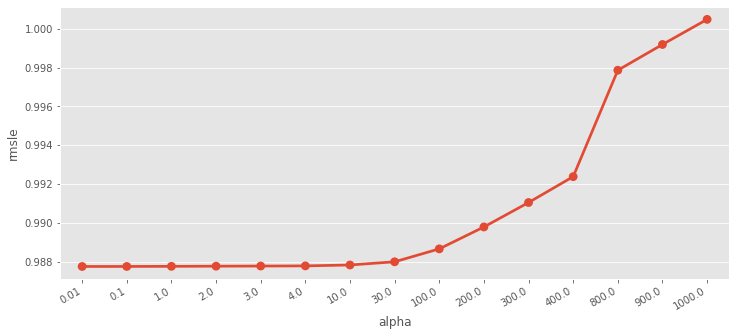

In [102]:

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

{'alpha': 0.00125, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9803727821457648


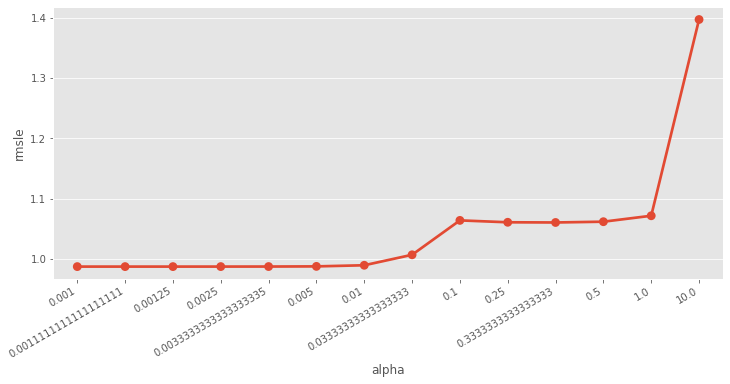

In [103]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( X_train , y_train_log )
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(preds),False))


fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)


In [104]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.10693926922005902


In [60]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.2135740372724937


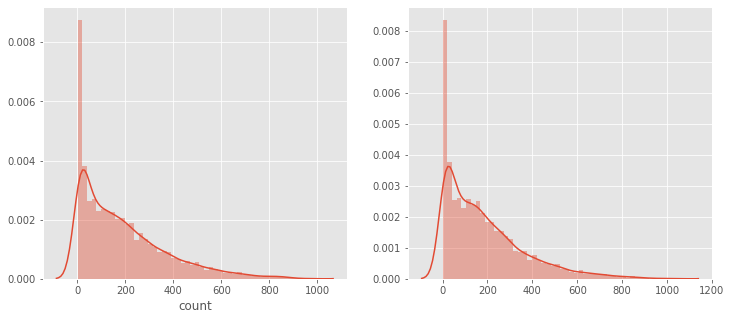

In [49]:
predsTest = gbm.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [83]:
submission = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/sampleSubmission.csv")
submission

submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,11.227543
1,2011-01-20 01:00:00,6.296610
2,2011-01-20 02:00:00,4.259238
3,2011-01-20 03:00:00,2.666615
4,2011-01-20 04:00:00,2.295918


In [84]:
submission.to_csv("/content/drive/My Drive/Colab Notebooks/data/Score_{0:.5f}_submission.csv".format(score), index=False)

In [105]:
144/3251

0.04429406336511842